In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# Imports and data loading

## General imports

In [ ]:
import os
import gc
import sys
import cv2
import json
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import seaborn as sns
from pathlib import Path
from google.colab import files
import matplotlib.image as mpimg
from matplotlib import pyplot as plt
from imgaug import augmenters as iaa

from vision import refine_masks, resize_image

!pip uninstall kaggle -q
!pip install kaggle -q
!pip install tensorflow-gpu==1.15 -qq
!pip install keras==2.1.5 -q -qq

import keras
import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Proceed (y/n)? y
     |████████████████████████████████| 61kB 1.9MB/s 
     |████████████████████████████████| 411.5MB 35kB/s 
     |████████████████████████████████| 512kB 65.2MB/s 
     |████████████████████████████████| 51kB 7.9MB/s 
     |████████████████████████████████| 3.8MB 61.6MB/s 
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 1.15.0 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-estimator 1.15.1 which is incompatible.
ERROR: tensorflow-probability 0.11.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
     |████████████████████████████████| 337kB 2.7MB/s 


Using TensorFlow backend.


## Download dataset

In [ ]:
%%time 
# Get the data
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle competitions download -c imaterialist-fashion-2020-fgvc7
# Unzip the file
!unzip -qq '/content/imaterialist-fashion-2020-fgvc7.zip'
# Clone Mask_RCNN
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')
!rm -rf .git
!rm -rf images assets
# Import Mask_RCNN
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
# Get mask_rcnn_coco
!wget --quiet https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5
!ls -lh mask_rcnn_coco.h5

DATA_DIR = '/content'
COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

Saving kaggle.json to kaggle.json
100% 19.2G/19.2G [04:01<00:00, 73.2MB/s]
100% 19.2G/19.2G [04:01<00:00, 85.5MB/s]
Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.77 MiB | 50.90 MiB/s, done.
Resolving deltas: 100% (564/564), done.
-rw-r--r-- 1 root root 246M Nov 26  2017 mask_rcnn_coco.h5
CPU times: user 2.23 s, sys: 574 ms, total: 2.8 s
Wall time: 14min 43s


In [ ]:
with open('/content/label_descriptions.json', 'r') as file:
    label_desc = json.load(file)
sample_sub_df = pd.read_csv('/content/sample_submission.csv')
train_df = pd.read_csv('/content/train.csv')

# Visualize the data

In [ ]:
# def create_mask(image_id):
#     masks = []

#     img = mpimg.imread(f'/content/train/{image_id}.jpg')
#     shape = img.shape
#     encoded_pixels = list(train_df[train_df['ImageId'] == image_id]['EncodedPixels'])
#     class_ids = list(train_df[train_df['ImageId'] == image_id]['ClassId'])
      
#     # Initialize numpy array with shape same as image size
#     height, width = shape[:2]
#     mask = np.zeros((height, width)).reshape(-1)
      
#     # Iterate over encoded pixels and create mask
#     for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
#         splitted_pixels = list(map(int, pixel_str.split()))
#         pixel_starts = splitted_pixels[::2]
#         run_lengths = splitted_pixels[1::2]
#         assert max(pixel_starts) < mask.shape[0]
#         for pixel_start, run_length in zip(pixel_starts, run_lengths):
#             mask[int(pixel_start) - 1 : int(pixel_start) - 1 + int(run_length)] = 255 - class_id * 4
#     masks.append(mask.reshape((height, width), order='F'))
#     return masks

In [ ]:
# def create_mask(size):
#     image_ids = train_df['ImageId'].unique()[:size]
#     images_meta=[]
#     masks = []

#     for image_id in image_ids:
#         img = mpimg.imread(f'/content/train/{image_id}.jpg')
#         shape = img.shape
#         encoded_pixels = list(train_df[train_df['ImageId'] == image_id]['EncodedPixels'])
#         class_ids = list(train_df[train_df['ImageId'] == image_id]['ClassId'])
        
#         images_meta.append({
#             'image': img,
#             'shape': shape,
#             'encoded_pixels': train_df[train_df['ImageId'] == image_id]['EncodedPixels'],
#             'class_ids': train_df[train_df['ImageId'] == image_id]['ClassId']
#         })
        
#         # Initialize numpy array with shape same as image size
#         height, width = shape[:2]
#         mask = np.zeros((height, width)).reshape(-1)
        
#         # Iterate over encoded pixels and create mask
#         for segment, (pixel_str, class_id) in enumerate(zip(encoded_pixels, class_ids)):
#             splitted_pixels = list(map(int, pixel_str.split()))
#             pixel_starts = splitted_pixels[::2]
#             run_lengths = splitted_pixels[1::2]
#             assert max(pixel_starts) < mask.shape[0]
#             for pixel_start, run_length in zip(pixel_starts, run_lengths):
#                 mask[int(pixel_start) - 1 : int(pixel_start) - 1 + int(run_length)] = 255 - class_id * 4
#         masks.append(mask.reshape((height, width), order='F'))
#     return masks, images_meta

In [ ]:
# def plot_segmented_images(size=4, figsize=(14, 14)):
#     # First create masks from given segments
#     masks, images_meta = create_mask(size)
    
#     # Plot images in groups of 4 images
#     n_groups = 4
    
#     count = 0
#     for index in range(size // 4):
#         fig, ax = plt.subplots(nrows=2, ncols=2, figsize=figsize)
#         for row in ax:
#             for col in row:
#                 col.imshow(images_meta[count]['image'])
#                 col.imshow(masks[count], alpha=0.75)
#                 col.title.set_text('Categories:\n' \
#                                    + ', '.join(["[" + categories_df[categories_df.id == x].name.values[0] + "]"\
#                                                 for x in images_meta[count]['class_ids'].values]))
#                 col.axis('off')
#                 count += 1
#         plt.show()
#     gc.collect()

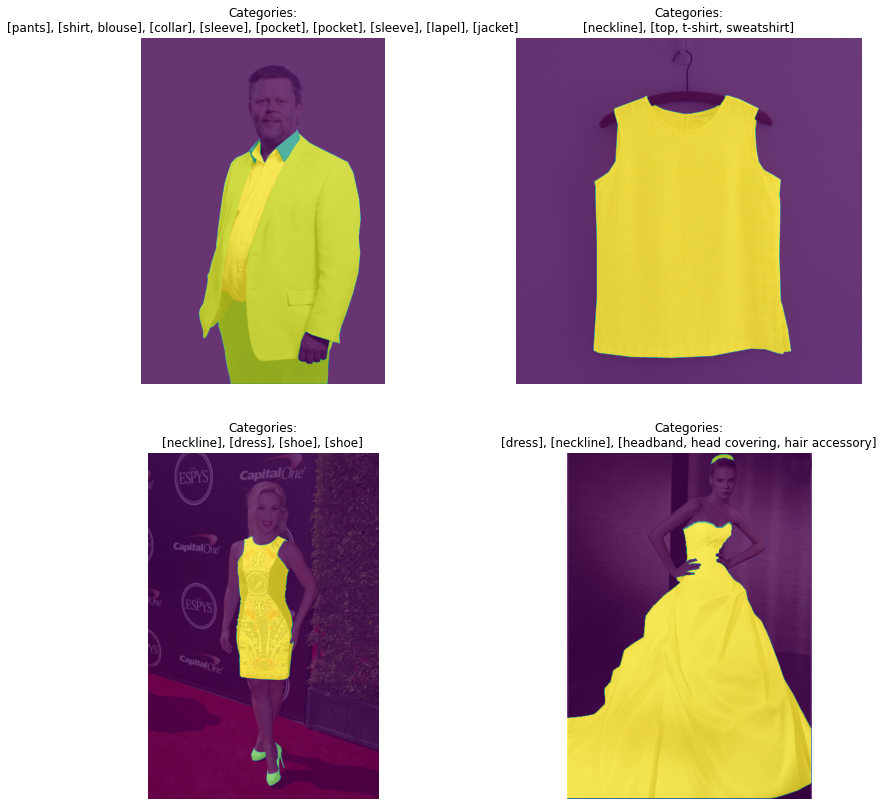

In [ ]:
# plot_segmented_images()

# Preproccesing

In [ ]:
categories_df = pd.DataFrame(label_desc.get('categories'))

In [ ]:
image_df = train_df.groupby('ImageId')['EncodedPixels', 'ClassId'].agg(lambda x: list(x))
size_df = train_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [ ]:
class FashionConfig(Config):
    """Configuration for training on the toy shapes dataset.
    Derives from the base Config class and overrides values specific
    to the toy shapes dataset.
    """
    # Give the configuration a recognizable name
    NAME = "class"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + len(categories_df)  # background + 46 classes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256*4
    IMAGE_MAX_DIM = 256*4

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 10

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 20000//(GPU_COUNT*IMAGES_PER_GPU) # 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 100 # 10623//(GPU_COUNT*IMAGES_PER_GPU)

    LEARNING_RATE = 0.001
    LEARNING_RATE_TUNE = 0.0001

    # LOSS_WEIGHTS = {
    #       "rpn_class_loss": 1.0, # How well the Region Proposal Network separates background with objetcs
    #       "rpn_bbox_loss": 0.8, # How well the RPN localize objects
    #       "mrcnn_class_loss": 6.0, # How well the Mask RCNN localize objects
    #       "mrcnn_bbox_loss": 6.0, # How well the Mask RCNN recognize each class of object
    #       "mrcnn_mask_loss": 6.0 # How well the Mask RCNN segment objects
    # }
    
        
config = FashionConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  1024
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LEARNING_RATE_TUNE             0.0001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 0.8, 'mrcnn_class_loss': 6.0, 'mrcnn_bbox_loss': 6.0, 'mrcnn_mask_loss': 6.0}
MASK_POOL_SIZE

In [ ]:
class FashionDataset(utils.Dataset):
    def __init__(self, df):
        super().__init__(self)
        
        self.IMAGE_SIZE = 256*4
        
        # Add classes
        for cat in label_desc['categories']:
            self.add_class('fashion', cat.get('id'), cat.get('name'))
        
        # Add images
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=DATA_DIR + os.sep + 'train' + os.sep + row.name + '.jpg', 
                           labels=row['ClassId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])
            
    def _resize_image(self, image_path):
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
        return img
        
    def load_image(self, image_id):
        return self._resize_image(self.image_info[image_id]['path'])
    
    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [x for x in info['labels']]
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
                
        mask = np.zeros((self.IMAGE_SIZE, self.IMAGE_SIZE, len(info['annotations'])), dtype=np.uint8)
        labels = []
        
        for m, (annotation, label) in enumerate(zip(info['annotations'], info['labels'])):
            sub_mask = np.full(info['height']*info['width'], 0, dtype=np.uint8)
            annotation = [int(x) for x in annotation.split(' ')]
            
            for i, start_pixel in enumerate(annotation[::2]):
                sub_mask[start_pixel: start_pixel+annotation[2*i+1]] = 1

            sub_mask = sub_mask.reshape((info['height'], info['width']), order='F')
            sub_mask = cv2.resize(sub_mask, (self.IMAGE_SIZE, self.IMAGE_SIZE), interpolation=cv2.INTER_NEAREST)
            
            mask[:, :, m] = sub_mask
            labels.append(int(label)+1)
            
        return mask, np.array(labels)

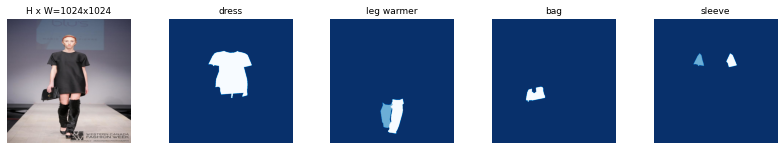

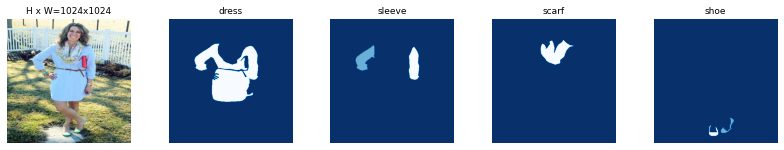

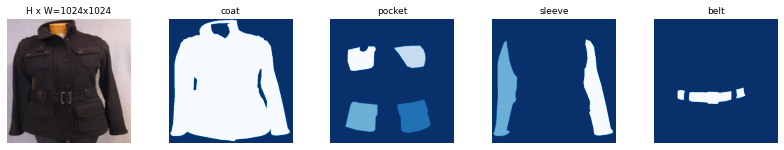

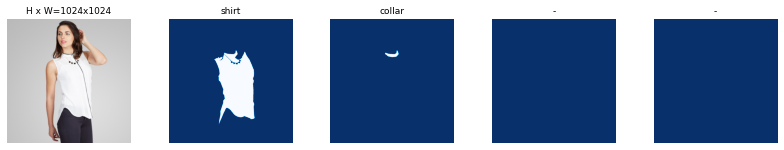

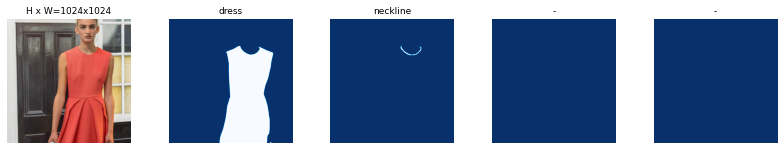

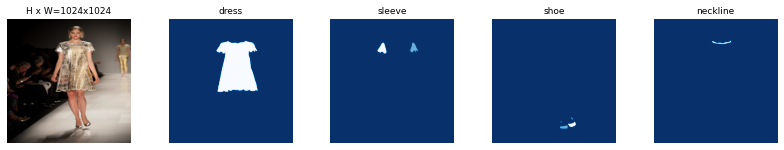

In [ ]:
dataset = FashionDataset(image_df)
dataset.prepare()

for i in range(6):
    image_id = random.choice(dataset.image_ids)

    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names, limit=4)

In [ ]:
# FOLD = 0
# N_FOLDS = 2

# kf = KFold(n_splits=N_FOLDS, random_state=42, shuffle=True)
# splits = kf.split(image_df) # ideally, this should be multilabel stratification

# def get_fold():    
#     for i, (train_index, valid_index) in enumerate(splits):
#         if i == FOLD:
#             return image_df.iloc[train_index], image_df.iloc[valid_index]
        
# train_df, valid_df = get_fold()

train_df = image_df.iloc[:35000]
valid_df = image_df.iloc[35000:]

train_dataset = FashionDataset(train_df)
train_dataset.prepare()

valid_dataset = FashionDataset(valid_df)
valid_dataset.prepare()

In [ ]:
print(f"train_df: {train_df.shape[0]}, valid_df: {valid_df.shape[0]}")

train_df: 35000, valid_df: 10623


In [ ]:
# augmentation = iaa.Sequential([iaa.Fliplr(0.5),
#                               iaa.Dropout(p=(0, 0.2), per_channel=0.5),
#                               iaa.MedianBlur(k=(3, 11))])

augmentation = iaa.Sequential([
    ## ref. Kaggle starter code
    ## Image rotation, translation, flipping:
    iaa.OneOf([
        iaa.Fliplr(0.2),
        iaa.Affine(
            scale = {"x": (0.99,1.01), "y":(0.98,1.03)},
            translate_percent = {"x": (-0.025,0.025), "y": (-0.05,0.05)}
        ),
    ]),
    ## Adjustment of contrast or resolution:
    iaa.OneOf([
        iaa.ContrastNormalization((0.75, 1.05)),
        iaa.GaussianBlur(sigma=(0.0, 0.1)),
    ]),
])

In [ ]:
print(f"train class mean: {train_df.ClassId.apply(lambda x: len(x)).mean()} \nvalidation class mean: {valid_df.ClassId.apply(lambda x: len(x)).mean()}")

train class mean: 7.288971428571428 
validation class mean: 7.369575449496375


In [ ]:
import warnings 
warnings.filterwarnings("ignore")
tf.get_logger().setLevel('ERROR')

In [ ]:
%%time

model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')

model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"]) 
 
## train heads with higher lr to speedup the learning
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE*2, # train heads with higher lr to speedup learning
            epochs=1,
            layers='heads',
            augmentation=None) 
history = model.keras_model.history.history
 
 
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE,
            epochs=4,
            layers='all',
            augmentation=augmentation)
 
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
 
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE,
            epochs=8,
            layers='all',
            augmentation=augmentation)
 
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE,
            epochs=8,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_0007.h5
Re-starting from epoch 7

Starting at epoch 7. LR=0.0001

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (Bat

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE,
            epochs=10,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_0008.h5
Re-starting from epoch 8

Starting at epoch 8. LR=0.0001

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (Bat

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE/10,
            epochs=12,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_0010.h5
Re-starting from epoch 10

Starting at epoch 10. LR=1e-05

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (Ba

#### Run train with LOSS_WEIGHTS 

In [ ]:
%%time

model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')

model.load_weights(COCO_WEIGHTS_PATH, by_name=True,
                   exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                            "mrcnn_bbox", "mrcnn_mask"]) 
 
## train heads with higher lr to speedup the learning
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE*2, # train heads with higher lr to speedup learning
            epochs=1,
            layers='heads',
            augmentation=None) 
history = model.keras_model.history.history
 
 
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE,
            epochs=4,
            layers='all',
            augmentation=augmentation)
 
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]
 
model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE,
            epochs=8,
            layers='all',
            augmentation=augmentation)
 
new_history = model.keras_model.history.history
for k in new_history: history[k] = history[k] + new_history[k]


Starting at epoch 0. LR=0.002

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200820T1238/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4   

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE,
            epochs=8,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200820T1238/mask_rcnn_class_0004.h5
Re-starting from epoch 4

Starting at epoch 4. LR=0.0001

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200820T1238/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (Bat

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')


# Load weights trained on MS COCO, but skip layers that
# are different due to the different number of classes
# See README for instructions to download the COCO weights

model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

model.train(train_dataset, valid_dataset,
            learning_rate=config.LEARNING_RATE_TUNE/2,
            epochs=10,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200820T1238/mask_rcnn_class_0007.h5
Re-starting from epoch 7

Starting at epoch 7. LR=5e-05

Checkpoint Path: /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200820T1238/mask_rcnn_class_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (Batc

In [ ]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [ ]:
class InferenceConfig(config.__class__):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir='/content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7')

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /content/drive/My Drive/iMaterialist (Fashion) 2020 at FGVC7/class20200810T0909/mask_rcnn_class_0008.h5
Re-starting from epoch 8


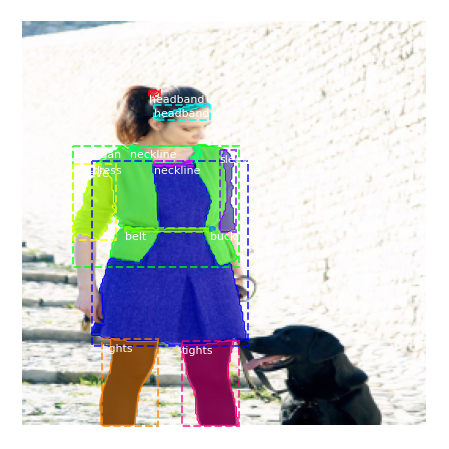

In [ ]:
# Test on a random image
image_id = random.choice(dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, inference_config, 
                           image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


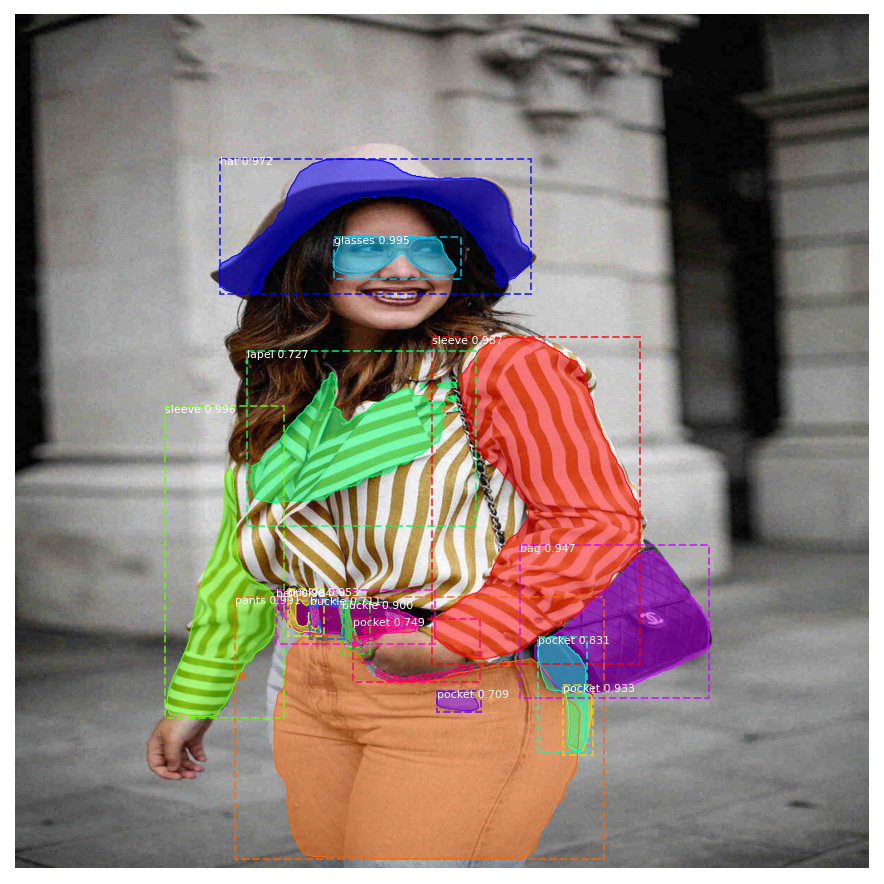

In [ ]:
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            valid_dataset.class_names, r['scores'], ax=get_ax())

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 59)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.17695  max:    1.11439  float32


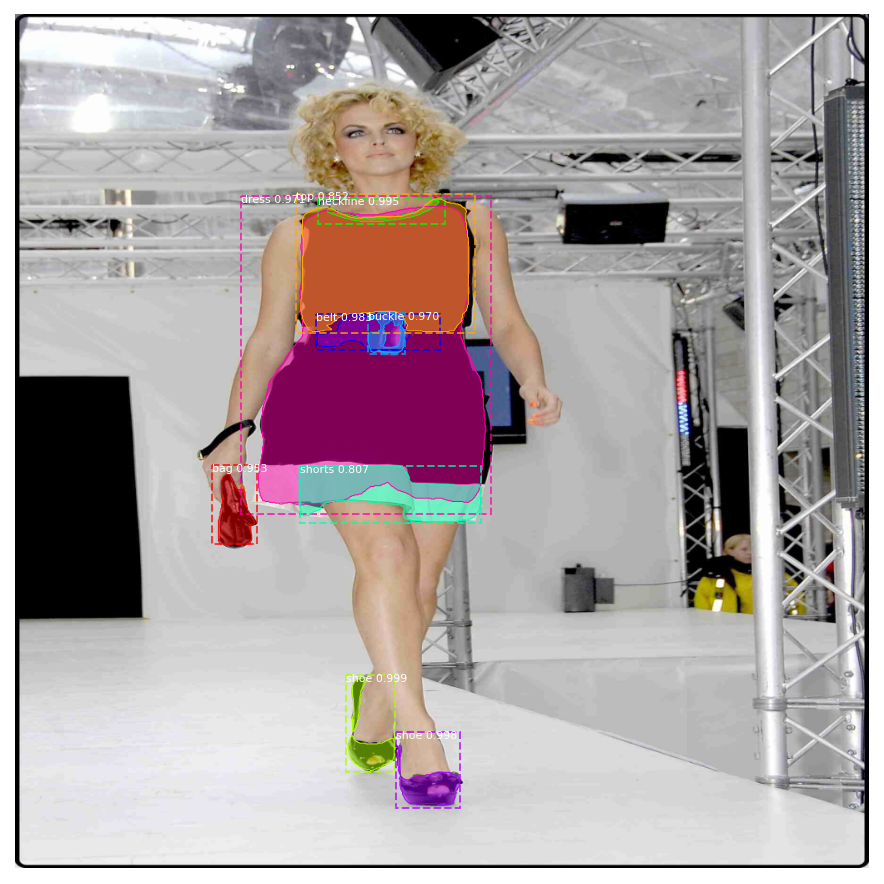

In [ ]:
image_id = 6920
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            valid_dataset.class_names, r['scores'], ax=get_ax())

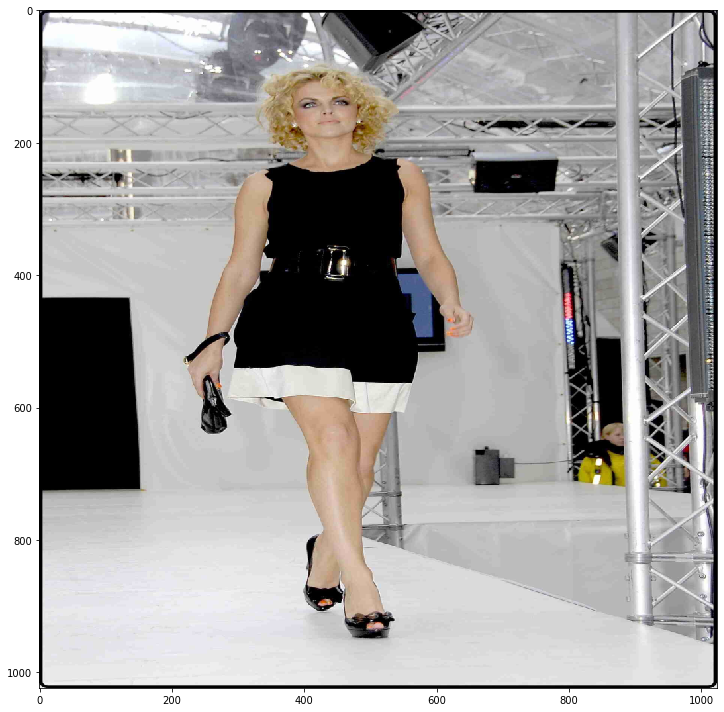

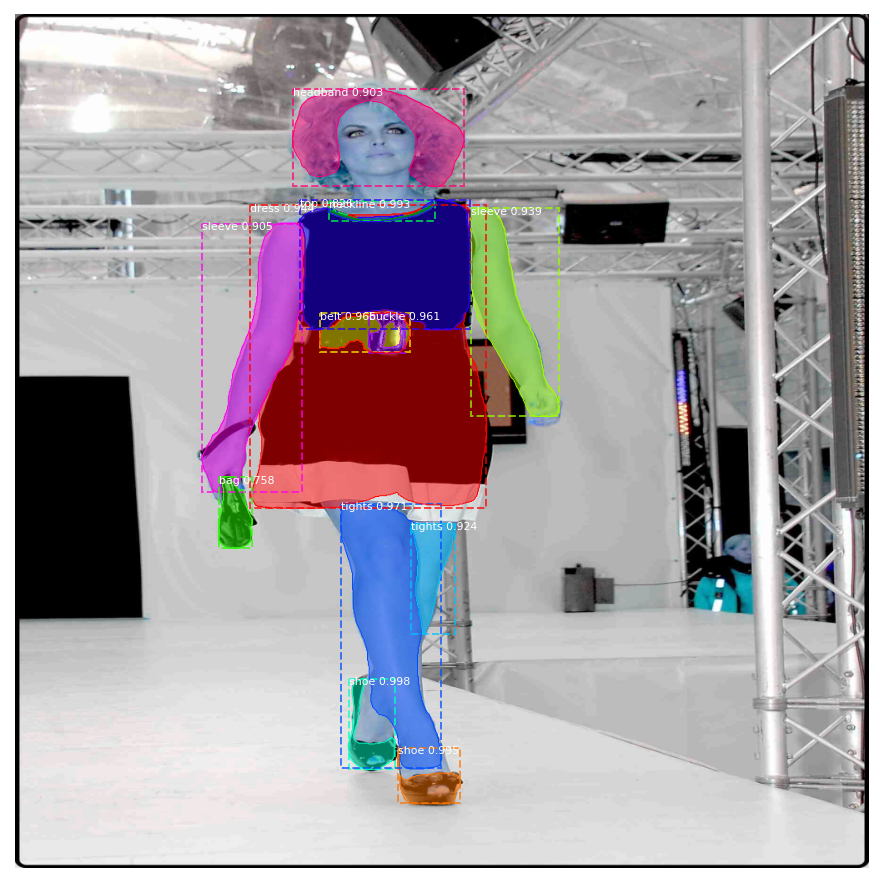

In [ ]:
import skimage.io

# original image
plt.figure(figsize=(12,10))
skimage.io.imshow(original_image)

img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(original_image)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/config.IMAGE_MAX_DIM
    x_scale = img.shape[1]/config.IMAGE_MAX_DIM
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], valid_dataset.class_names, r['scores'])

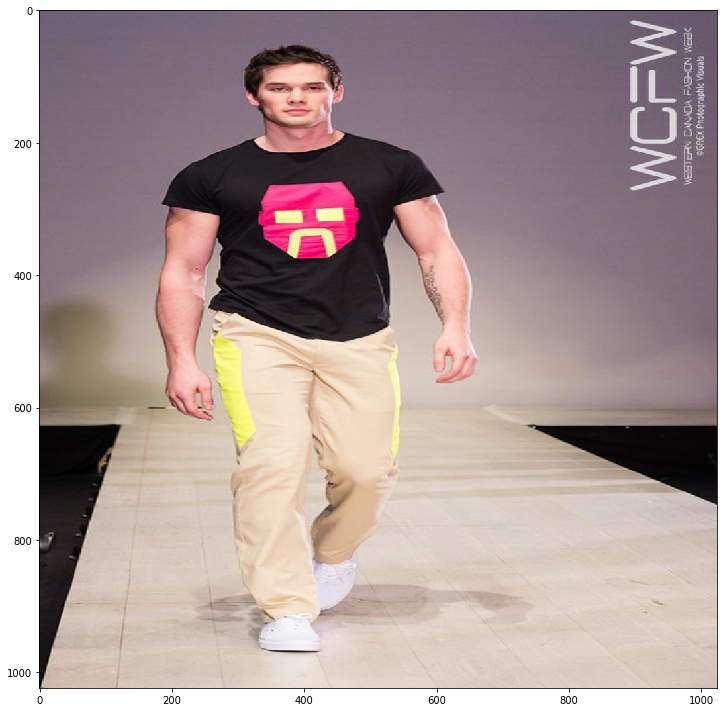

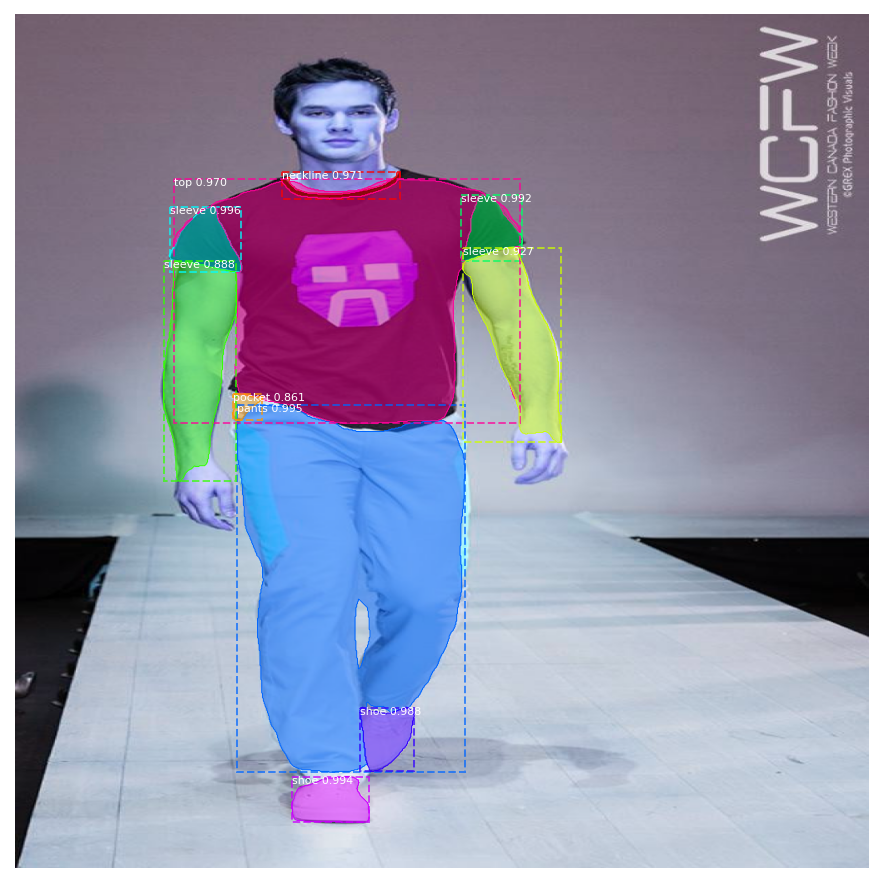

In [ ]:
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

plt.figure(figsize=(12,10))
skimage.io.imshow(original_image)

img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(original_image)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/config.IMAGE_MAX_DIM
    x_scale = img.shape[1]/config.IMAGE_MAX_DIM
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], valid_dataset.class_names, r['scores'])

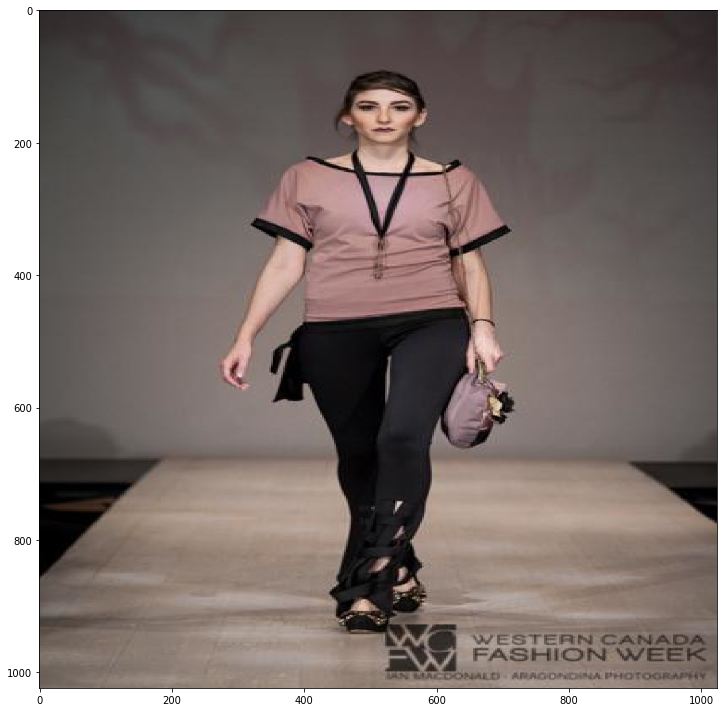

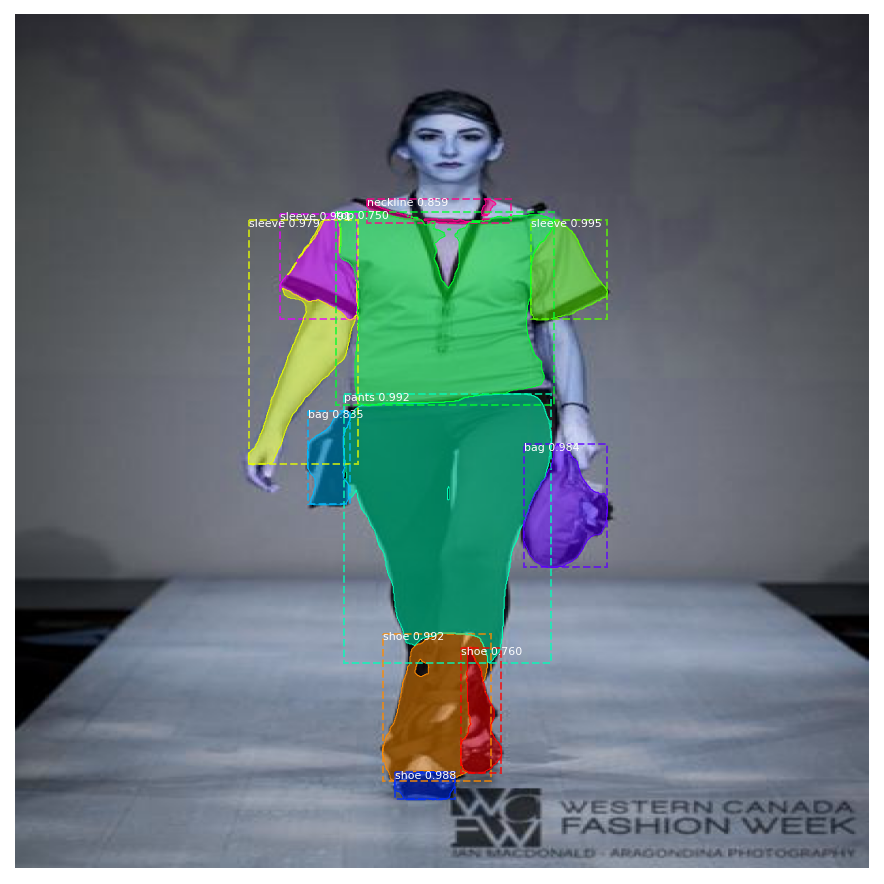

In [ ]:
image_id = random.choice(valid_dataset.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(valid_dataset, inference_config, 
                           image_id, use_mini_mask=False)

plt.figure(figsize=(12,10))
skimage.io.imshow(original_image)

img = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

result = model.detect([resize_image(original_image)])
r = result[0]

if r['masks'].size > 0:
    masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
    for m in range(r['masks'].shape[-1]):
        masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                    (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
    
    y_scale = img.shape[0]/config.IMAGE_MAX_DIM
    x_scale = img.shape[1]/config.IMAGE_MAX_DIM
    rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
    
    masks, rois = refine_masks(masks, rois)
else:
    masks, rois = r['masks'], r['rois']
    
visualize.display_instances(img, rois, masks, r['class_ids'], valid_dataset.class_names, r['scores'])